<a href="https://colab.research.google.com/github/Artmalik92/Congruence-Test-For-Students/blob/main/geometry_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В системах геодезического мониторинга одним из методов обнаружения деформаций является построение ГНСС сетей и анализ движений в них при помощи вычисления невязок в замкнутых фигурах или геометрической модели. Геометрическая модель использует геометрические свойства объектов. Например, можно использовать геометрические связи между точками (углы и расстояния) для определения их относительного положения и оценки стабильности измерений. Данный принцип можно реализовать в виде программы геометрического теста на Python.

Геометрический тест стабильности позволяет выявлять аномальные движения в замкнутой геодезической сети путем вычисления разностей параметров этой сети (внутренних углов, длин базовых линий или координат) на начальную и i-ую эпоху. После этого производится статистическая оценка разностей. Если сумма разностей между параметрами статистически не значима, то эти две фигуры конгруэнтны, т. е. аномальных движений нет.

Библиотеки, которые нам понадобятся:

In [26]:
import pandas
import numpy
from scipy.stats import chi2
from scipy.linalg import block_diag

Библиотека **pandas** необходима для обработки и структурирования данных в виде таблиц.
**Numpy** используется для выполнения математических операций с матрицами и другими массивами. **Scipy** содержит модуль **stats**, который позволяет выполнять в Python статистические операции, в частности тест Хи-квадрат, который мы будем использовать. Модуль linalg позволяет составлять блочные диагональные матрицы, он понадобится нам при выполнении линейной регрессии.

Для начала подготовим тестовый временной ряд координат, на котором будем испытывать код программы:

In [55]:
def generate_coordinates(noise, observations, start_coordinate, offset=None):

    # сгенерируем координаты без смещений
    segment = numpy.full(observations*7, start_coordinate)

    # объединяем сегменты в один массив
    Coordinates = numpy.hstack([segment]).astype(float)

    if offset:
        # сгенерируем несколько сегментов временного ряда координаты U со смещением
        segment_1 = numpy.full(observations, start_coordinate + offset)
        segment_2 = numpy.full(observations, start_coordinate + offset*2)
        segment_3 = numpy.full(observations, start_coordinate + offset*3)
        segment_4 = numpy.full(observations, start_coordinate + offset*4)
        segment_5 = numpy.full(observations, start_coordinate + offset*5)
        segment_6 = numpy.full(observations, start_coordinate + offset*6)
        segment_7 = numpy.full(observations, start_coordinate + offset*7)

        # объединяем сегменты в один массив
        Coordinate_U = numpy.hstack([segment_1, segment_2, segment_3,
                                segment_4, segment_5, segment_6,
                                segment_7]).astype(float)

    else:
        # сгенерируем координаты U но без смещений
        Coordinate_U = numpy.hstack([segment]).astype(float)

    # добавляем шум в измерения в виде случайного числа с разбросом 0.005
    Coordinates += numpy.random.normal(0, noise, observations*7)
    Coordinate_U += numpy.random.normal(0, noise, observations*7)

    # Добавляем столбцы с СКП
    sigmas = numpy.hstack([numpy.ones(observations*7)*noise])

    # преобразуем в таблицу DataFrame для дальнейшего использования
    df = pandas.DataFrame({0: Coordinates,
                        1: Coordinates + 0.1,
                        2: Coordinate_U + 0.2,
                        3: sigmas, 4: sigmas, 5: sigmas})

    return df

              0           1           2      3      4      5
0     99.998461  100.098461  100.250734  0.005  0.005  0.005
1     99.988037  100.088037  100.245980  0.005  0.005  0.005
2    100.004899  100.104899  100.253796  0.005  0.005  0.005
3     99.996646  100.096646  100.249585  0.005  0.005  0.005
4    100.000696  100.100696  100.245927  0.005  0.005  0.005
..          ...         ...         ...    ...    ...    ...
345   99.994556  100.094556  100.549349  0.005  0.005  0.005
346   99.993143  100.093143  100.543456  0.005  0.005  0.005
347   99.995957  100.095957  100.554252  0.005  0.005  0.005
348  100.003463  100.103463  100.557783  0.005  0.005  0.005
349  100.003898  100.103898  100.552533  0.005  0.005  0.005

[350 rows x 6 columns]


<Axes: >

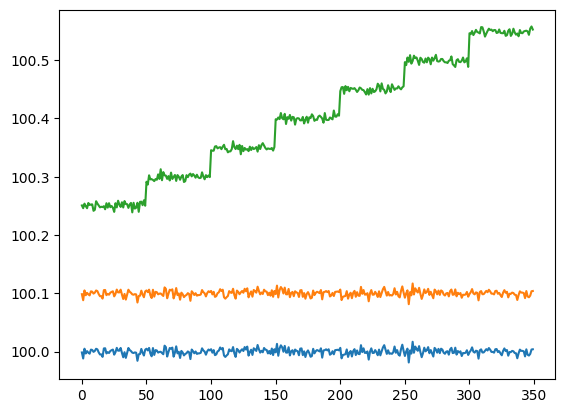

In [56]:
''' Исходные данные '''
noise = 0.005           # Амплитуда шума в измерениях
offset = 0.05           # Амплитуда смещения координаты
observations = 50       # количество измерений

df1 = generate_coordinates(noise=noise, observations=observations,
                           start_coordinate=100, offset=offset)
df2 = generate_coordinates(noise=noise, observations=observations,
                           start_coordinate=50)
df3 = generate_coordinates(noise=noise, observations=observations,
                           start_coordinate=70)
df4 = generate_coordinates(noise=noise, observations=observations,
                           start_coordinate=95)

print(df1)

# выводим график на экран
df1[0].plot()
df1[1].plot()
df1[2].plot()

<Axes: >

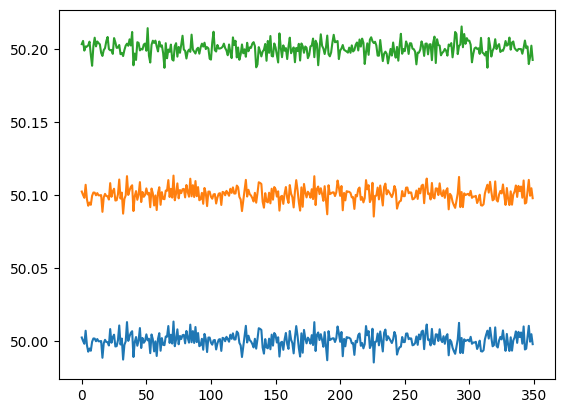

In [57]:
df2[0].plot()
df2[1].plot()
df2[2].plot()

In [58]:
def geometric_chi_test_calc2(time_series_frag, sigma_0) :
    #переделка массива с координатами вобщий вектор свлбодных членов
    L=numpy.zeros((time_series_frag.shape[0]*3))
    Q=numpy.zeros((time_series_frag.shape[0]*3,time_series_frag.shape[0]*3))
    for i in range (time_series_frag.shape[0]) :
        L[3*i]=time_series_frag.iloc[i][0]
        L[3*i+1]=time_series_frag.iloc[i][1]
        L[3*i+2]=time_series_frag.iloc[i][2]
        Q[3*i,3*i]=time_series_frag.iloc[i][3]**2
        Q[3*i+1,3*i+1]=time_series_frag.iloc[i][4]**2
        Q[3*i+2,3*i+2]=time_series_frag.iloc[i][5]**2
    # задаем массив эпох
    t=numpy.arange(0, time_series_frag.shape[0], 1)
    # цикл формирования матрицы коэффициентов
    for m in range (time_series_frag.shape[0]):
        ti=t[m]
        if m==0 : A=numpy.hstack((numpy.identity(3)*ti, numpy.identity(3)))
        else:
            Aux=numpy.hstack((numpy.identity(3)*ti, numpy.identity(3)))
            A=numpy.vstack((A, Aux))

    #формирование матрицы весов

    P=Q/sigma_0**2
    # решаем СЛАУ
    N = A.transpose().dot(numpy.linalg.inv(P)).dot(A)
    X = numpy.linalg.inv(N).dot(A.transpose().dot(numpy.linalg.inv(P)).dot(L)) # вектор параметров кинематической модели
    x_LS=numpy.array([X[0]*t[-1]+X[3], X[1]*t[-1]+X[4], X[2]*t[-1]+X[5]])

    #вычисляем вектор невязок
    V=A.dot(X)-L#

    # СКП единицы веса
    mu= numpy.sqrt((V.transpose().dot(numpy.linalg.inv(P)).dot(V))/(V.shape[0]-6))

    Qx=numpy.linalg.inv(N)#*mu**2 по идее нужное действие, но оно как раз все портит/ без умножения на mu**2
    С=numpy.array([[t[-1],0,0,1,0,0],[0,t[-1],0,0,1,0],[0,0,t[-1],0,0,1]])

    Qv=С.dot(Qx).dot(С.transpose())


    return (x_LS,Qv,mu, Qx,V)

In [75]:
def geometric_chi_test_statictics (time_serieses_df, window, sigma_0):
    time_series_df=time_serieses_df[0]
    epochs=int(time_series_df.shape[0]/window)
    X_WLS=numpy.ndarray(shape=(epochs,1,12))
    Qv_WLS=numpy.ndarray(shape=(epochs,3*4,3*4))
    mu_WLS=numpy.zeros(epochs)
    time_series_df=time_serieses_df[0]


    end=0
    for j in range (epochs) :
        st=end
        end=int((j+1)*window)


        x_LS1,Qv1,mu1, Qx, V=geometric_chi_test_calc2(df1.iloc[st:end],0.005)
        x_LS2,Qv2,mu2, Qx, V=geometric_chi_test_calc2(df2.iloc[st:end],0.005)
        x_LS3,Qv3,mu3, Qx, V=geometric_chi_test_calc2(df3.iloc[st:end],0.005)
        x_LS4,Qv4,mu4, Qx, V=geometric_chi_test_calc2(df4.iloc[st:end],0.005)

        mu_WLS[j]=mu1**2+mu2**2+mu3**2+mu4**2
        X_WLS[j]=numpy.hstack((x_LS1,x_LS2,x_LS3,x_LS4))
        Qv_WLS[j]=block_diag(Qv1,Qv2,Qv3,Qv4)
    test_statistic=numpy.zeros((epochs-1))

    rejected_epochs = []

    for l in range(epochs-1): # здесь косяки скорее всего. Нужно их исправлять
        Qdd=Qv_WLS[l]+ Qv_WLS[l+1]

        d=X_WLS[l]-X_WLS[l+1]

        sigma_0=mu_WLS[l]+mu_WLS[l+1]
        test_statistic[l]=d.dot(numpy.linalg.inv(Qdd)).dot(d.transpose())/sigma_0
        test_value = chi2.ppf(df=((d.shape[0])/3)*6, q=0.95)
        if test_statistic[l]>test_value :
            print('reject, l=',l*window)
            print('test_value =',test_value)
            print('test_statistic =',test_statistic[l])
            rejected_epochs.append(l*window)
    return X_WLS, Qv_WLS, test_statistic, rejected_epochs

In [76]:
X_WLS, Qv_WLS, test_statistic, rejected_epochs = geometric_chi_test_statictics(df1,5,0.05)

reject, l= 45
test_value = 5.991464547107979
test_statistic = 9.455269943924725
reject, l= 95
test_value = 5.991464547107979
test_statistic = 9.581236504519877
reject, l= 145
test_value = 5.991464547107979
test_statistic = 11.795155885695475
reject, l= 195
test_value = 5.991464547107979
test_statistic = 12.99104503444294
reject, l= 245
test_value = 5.991464547107979
test_statistic = 6.9878231866921405
reject, l= 295
test_value = 5.991464547107979
test_statistic = 17.150201352934403


<ipython-input-75-3e7bf6d5ae27>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_statistic[l]=d.dot(numpy.linalg.inv(Qdd)).dot(d.transpose())/sigma_0


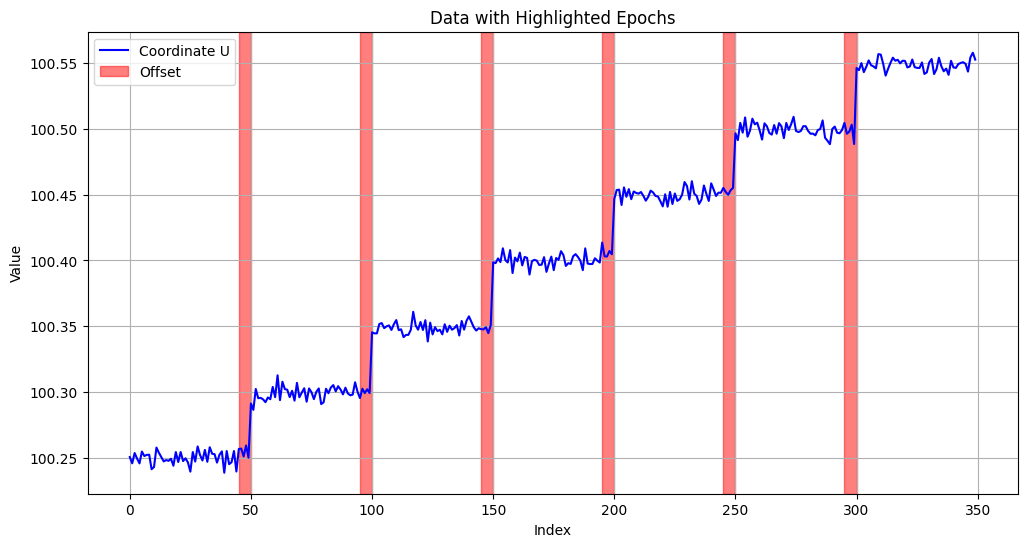

In [72]:
import matplotlib.pyplot as plt

# Create a plot
plt.figure(figsize=(12, 6))

# Plot the first column of the DataFrame
plt.plot(df1[2], label='Coordinate U', color='blue')

# Highlight the epochs
for epoch in rejected_epochs:
    plt.axvspan(epoch, epoch + 5, color='red', alpha=0.5, label=f'Offset' if epoch == rejected_epochs[0] else "")

# Add labels and title
plt.title('Data with Highlighted Epochs')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid()

# Show the plot
plt.show()